# Description
1. Focus on a single platform (e.g. Qiskit)
2. Create a random circuit
3. Create a function that, given a progam, tells you which part of the software has been called (e.g. using cProfile)
4. Create a fitness function that given a databased of function called gives a score of fitness to the current quantum algorithm
5. Run an end-to-end optimization algorithm

In [90]:
# initialization
import numpy as np
import qiskit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

In [3]:
from qiskit import Aer, transpile
from qiskit.providers.aer import AerError

# Initialize a GPU backend
# Note that the cloud instance for tutorials does not have a GPU
# so this will raise an exception.
try:
    simulator_gpu = Aer.get_backend('aer_simulator')
    simulator_gpu.set_options(device='GPU')
except AerError as e:
    print(e)

In [86]:
# generation function
from qiskit.circuit import qpy_serialization
from typing import List
import math

QASM_HEADER = """
OPENQASM 2.0;
include "qelib1.inc";
"""

gate_set = {
   "cx": 3, 
    "rx": 1, 
    "ry": 1, 
    "rz": 1, 
    "p": 1
}

# create a random circuit's encoding
instance_of_random_encoding = np.random.rand(100)

# convert the encoding in a quantum computer
def slot_to_gate(gates, gate_weights):
    mapping_dict = dict()
    slot_to_assign = 0
    for gate, number_of_slots in zip(gates, gate_weights):
        for slot in range(number_of_slots):
            mapping_dict[slot_to_assign] = gate
            slot_to_assign += 1
    return mapping_dict


def param_to_gate(param, gate_set):
    map_slot_to_gate = slot_to_gate(gate_set.keys(), gate_set.values())
    slots = sum(gate_set.values())
    op_type = map_slot_to_gate[int(param / (float(1) / slots))]
    return op_type

#def param_to_qubit(param, available_indices):
    

# Convert that encoding to a qasm string
def encoding_to_circuit(encoding: List[float], n_qubits: int, classical_input: int = None):
    """Convert encoding to a qasm string.
    
    We have a list to encode the single operation, the final list looks like:
    (0.23, 0.75, 0.76, 0.44, etc)
    (gate_type, qubit, parameter, gate_type, qubit, parameter, etc...)
    The single operation is made of three floats: 
    (gate_type, qubit, parameter)
    The first float encodes the gate. We divide the interval uniformly 
    on the available gates:
    - CNOT
    - pauli X
    - pauli Y
    - pauli Z
    - pahse shift
    The second float encodes the qubit on which it applies to. We divide the
    interval uniformly on the available qubits.
    The third float is used only by:
    - cnot gate: to select a target qubit (similarly to the first flaot)
    - phase shift: to select the rotation
    Based on the second digit we decide on which qubit it acts on
    
    """
    circuit_qasm = QASM_HEADER
    qubits = range(n_qubits)
    
    # add quantum and classical registers
    circuit_qasm += f"qreg q[{n_qubits}];\n"
    circuit_qasm += f"creg c[{n_qubits}];\n"
    
    
    if classical_input != None:
        assert isinstance(classical_input, int)
        format_string = "{0:" + str(n_qubits) + "b}"
        string_input = format_string.format(classical_input).zfill(n_qubits)
        for i, c in enumerate(string_input):
            if c == "1": 
                circuit_qasm += f"x q[{i}];\n"
    
    circuit_qasm += f"barrier q;\n"
    
    
    # get the single chunks
    n = 3  # number of parameters per operation
    chunks = [encoding[i:i + n] for i in range(0, len(encoding), n)]
    for op in chunks:
        # discard incomplete sequences
        if len(op) != 3: 
            continue
        # get the type of gate
        op_type = param_to_gate(param=op[0], gate_set=gate_set)
        #print(op_type, " : ", op[0])        
        
        try:
            # get target qubit
            qubit = qubits[int(op[1] / (float(1) / (len(qubits))))]
            #print(qubit, " : ", op[1])

            # extra parameter
            if op_type == "cx":
                # get second target qubit
                index_target = int(op[2] / (float(1) / (len(qubits) - 1)))
                if index_target >= qubit:
                    index_target += 1
                second_target_qubit = qubits[index_target]
                #print(second_target_qubit, " : ", op[2])
                #assert qubit == second_target_qubit, "Invalid encoding CNOT gate with same control and target qubit."
                circuit_qasm += f"cx q[{qubit}], q[{second_target_qubit}];\n"
            elif op_type == "p":
                # get rotation parameter
                parameter = 2 * math.pi * op[2]
                #print(parameter, " : ", op[2])
                circuit_qasm += f"U(0,{parameter},0) q[{qubit}];\n"
            else:
                parameter = 2 * math.pi * op[2]
                # call the simple X, Y, Z gate on a single qubit
                circuit_qasm += f"{op_type}({parameter}) q[{qubit}];\n"
        
        except IndexError: 
            print(f"op[0]: {op[0]}")
            print(f"op[1]: {op[1]}")
            print(f"op[2]: {op[2]}")
            print(f"op_type: {op_type}")
            print(f"qubit: {qubit}")
            print(f"second_target_qubit: {second_target_qubit}")
    circuit_qasm += f"barrier q;\n"
    # Measure
    circuit_qasm += f"measure q -> c;\n"
    return circuit_qasm


qasm_string = encoding_to_circuit(instance_of_random_encoding, n_qubits=10, classical_input=30)

random_circuit = QuantumCircuit.from_qasm_str(qasm_string)

random_circuit.draw()


░                                                   ┌────────────┐»
 q_0: ──────░───────■────────────────────────────────────────■──┤ Rz(3.3584) ├»
            ░       │         ┌────────────┐ ┌────────────┐  │  └────────────┘»
 q_1: ──────░───────┼─────────┤ Rz(5.1766) ├─┤ Ry(3.3197) ├──┼────────────────»
            ░       │         └───┬───┬────┘ └────────────┘  │                »
 q_2: ──────░───────┼─────────────┤ X ├──────────────────────┼────────────────»
            ░       │             └─┬─┘          ┌───┐       │  ┌────────────┐»
 q_3: ──────░───────┼───────────────┼────────────┤ X ├───────┼──┤ Ry(1.1216) ├»
            ░       │               │            └─┬─┘       │  ├────────────┤»
 q_4: ──────░───────┼───────────────■──────────────┼─────────┼──┤ Rx(3.3334) ├»
      ┌───┐ ░       │         ┌────────────┐       │         │  └────────────┘»
 q_5: ┤ X ├─░───────┼─────────┤ Rz(2.0083) ├───────┼─────────┼────────────────»
      ├───┤ ░     ┌─┴─┐     ┌─┴────────────┴┐      │         │                »
 q_6: ┤ X ├─░─────┤ X ├─────┤ U(0,1.9698,0) ├──────┼─────────┼────────────────»
      ├───┤ ░     └───┘     └───────────────┘      │         │                »
 q_7: ┤ X ├─░──────────────────────────────────────■─────────┼────────────────»
      ├───┤ ░ ┌────────────┐                                 │                »
 q_8: ┤ X ├─░─┤ Rz(1.3679) ├─────────────────────────────────┼────────────────»
      └───┘ ░ └────────────┘                               ┌─┴─┐┌───────────┐ »
 q_9: ──────░──────────────────────────────────────────────┤ X ├┤ Rz(4.924) ├─»
            ░                                              └───┘└───────────┘ »
c: 10/════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                                           »
« q_0: ─────────────────────────────────────────────────────────────────────»
«                                                          ┌───┐            »
« q_1: ────────────────────────────────────────────────────┤ X ├────────────»
«                    ┌─────────────┐  ┌───────────┐        └─┬─┘            »
« q_2: ──────■───────┤ Rz(0.31381) ├──┤ Ry(2.133) ├──────────┼───────────■──»
«            │       └┬────────────┤┌─┴───────────┴─┐        │           │  »
« q_3: ──────┼────────┤ Rz(6.0526) ├┤ U(0,4.5527,0) ├────────┼───────────┼──»
«            │        ├────────────┤└─┬────────────┬┘        │           │  »
« q_4: ──────┼────────┤ Rz(2.8866) ├──┤ Rz(5.0282) ├─────────■───────────┼──»
«          ┌─┴─┐      ├────────────┤  └────────────┘                     │  »
« q_5: ────┤ X ├──────┤ Ry(2.6748) ├────────■────────────────────────────┼──»
«          └───┘      └────────────┘        │                            │  »
« q_6: ─────────────────────────────────────┼────────────────────────────┼──»
«                                           │                          ┌─┴─┐»
« q_7: ─────────────────────────────────────┼──────────────────────────┤ X ├»
«                                           │                          └───┘»
« q_8: ─────────────────────────────────────┼───────────────────────────────»
«      ┌────────────┐ ┌────────────┐      ┌─┴─┐      ┌────────────────┐     »
« q_9: ┤ Ry(1.8549) ├─┤ Ry(3.4653) ├──────┤ X ├──────┤ U(0,0.70612,0) ├─────»
«      └────────────┘ └────────────┘      └───┘      └────────────────┘     »
«c: 10/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«                    ┌───┐                         ░ ┌─┐                     »
« q_0: ──────────────┤ X ├──■──────────────────────░─┤M├─────────────────────»
«                    └─┬─┘  │                      ░ └╥┘┌─┐                  »
« q_1: ────────────────┼────┼──────────────────────░──╫─┤M├──────────────────»
«                      │    │                      ░  ║ └╥┘┌─┐

In [66]:
import re 

def extract_function_calls(filepath):
    function_calls = []
    with open(filepath, 'r') as input_file:
        lines = input_file.readlines()
        for line in lines:
            m = re.search('site-packages(.+?)\n', line)
            if m:
                i_function_call = m.group(1)
                #i_function_call = l[l.rfind("site-packages"):]
                function_calls.append(i_function_call)
            
    return function_calls

In [67]:
# profile
import cProfile
import pstats
from qiskit import execute

def profile_program(circuit, backend, shots=1024):
    """Run the program and return results and called functions."""
    #print(circuit)
    #cProfile.runctx('my_job = execute(circuit, backend)', globals(), locals(), filename='c_profile_result.cprof')
    
    tmp_filepath = "c_profile_result.cprof"
    tmp_human_readable_filepath = "c_profile_result"
    
    prof = cProfile.Profile()
    my_job = prof.runcall(execute, circuit, backend)
    prof.dump_stats(tmp_filepath)
    
    result =  my_job.result()
    out_dict = result.get_counts()
    
    # write in a readable format
    with open(tmp_human_readable_filepath, "w") as f:
        ps = pstats.Stats(tmp_filepath, stream=f)
        ps.sort_stats('cumulative')
        ps.print_stats()
    
    # get the function calls
    function_calls = extract_function_calls(tmp_human_readable_filepath)
    
    return out_dict, function_calls 



In [74]:
i_result, i_fn_calls =  profile_program(circuit=random_circuit, backend=simulator_gpu)

In [69]:
i_result

{'0111110101': 1024}

In [71]:
len(i_fn_calls)

393

In [72]:
len(set(i_fn_calls))

393

In [75]:
len(i_fn_calls)

393

In [76]:
len(set(i_fn_calls))

393

# Fuzzing with random programs

In [83]:
def random_circuit_encoding(n_ops, random_state=None):
    if random_state is not None:
        assert isinstance(random_state, int)
        np.random.seed(random_state)
    return np.random.rand(3 * n_ops)

In [107]:
from random import randint

N_FUZZ = 100
MAX_QUBITS = 25
MAX_OPS = 100
MIN_OPS = 30
RANDOM_STATE = 42

records = []


for i in range(N_FUZZ):
    
    i_features = {}
    
    # choose how many operations
    i_ops = randint(MIN_OPS, MAX_OPS)
    i_ops['ops'] = i_ops
    
    # generate a random circuit
    i_encoding = random_circuit_encoding(
        n_ops=i_ops, random_state=RANDOM_STATE)
    i_features['encoding'] = i_encoding    
    
    # generate a random number of qubits
    i_qubits = randint(2, MAX_QUBITS + 1)
    i_features['qubits'] = i_qubits
    
    # generate a random input
    i_input = randint(0, 2**i_qubits)
    i_features['input'] = i_input
    
    print(f"Try {i} with {i_qubits} qubits and input: {i_input}")
    # create the qasm string (universal for cirq)
    i_qasm_string = encoding_to_circuit(
        i_encoding, 
        n_qubits=i_qubits, 
        classical_input=i_input)
    
    # create the circuit
    i_circuit = QuantumCircuit.from_qasm_str(i_qasm_string)
    
    # run and record
    i_result, i_fn_calls =  profile_program(
        circuit=i_circuit, backend=simulator_gpu)
    i_features['results'] = str(i_result)
    i_features['fn_calls'] = str(i_fn_calls)
    i_features['n_fn_calls'] = len(i_fn_calls)
    
    records.append(i_features)
    
df = pd.DataFrame.from_records(records)

Try 0 with 15 qubits and input: 25199
Try 1 with 11 qubits and input: 1331
Try 2 with 26 qubits and input: 3066241
Try 3 with 20 qubits and input: 411469
Try 4 with 12 qubits and input: 847
Try 5 with 14 qubits and input: 10389
Try 6 with 7 qubits and input: 122
Try 7 with 19 qubits and input: 233656
Try 8 with 16 qubits and input: 14920
Try 9 with 10 qubits and input: 493
Try 10 with 15 qubits and input: 23150
Try 11 with 25 qubits and input: 11131441
Try 12 with 25 qubits and input: 30399178
Try 13 with 14 qubits and input: 8773
Try 14 with 23 qubits and input: 6988017
Try 15 with 3 qubits and input: 5
Try 16 with 13 qubits and input: 16
Try 17 with 19 qubits and input: 469361
Try 18 with 8 qubits and input: 109
Try 19 with 22 qubits and input: 2702828
Try 20 with 18 qubits and input: 59922
Try 21 with 22 qubits and input: 2747024
Try 22 with 17 qubits and input: 110058
Try 23 with 14 qubits and input: 3492
Try 24 with 18 qubits and input: 215708
Try 25 with 2 qubits and input: 1
Try

In [108]:
df.head()

,random_encoding,qubits,input,results,fn_calls,n_fn_calls
0,"[0.3745401188473625, 0.9507143064099162, 0.731...",15,25199,"{'100101100001101': 1, '100001101011101': 1, '...","['/qiskit/execute_function.py:39(execute)', '/...",396
1,"[0.3745401188473625, 0.9507143064099162, 0.731...",11,1331,"{'11111101011': 1, '00001111001': 1, '10000110...","['/qiskit/execute_function.py:39(execute)', '/...",395
2,"[0.3745401188473625, 0.9507143064099162, 0.731...",26,3066241,"{'10110101101000110001001010': 1, '10110111100...","['/qiskit/execute_function.py:39(execute)', '/...",396
3,"[0.3745401188473625, 0.9507143064099162, 0.731...",20,411469,"{'11010110011000001000': 1, '11011110011000000...","['/qiskit/execute_function.py:39(execute)', '/...",395
4,"[0.3745401188473625, 0.9507143064099162, 0.731...",12,847,"{'101110000101': 1, '001110000001': 1, '101101...","['/qiskit/execute_function.py:39(execute)', '/...",395


/home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_fn_calls'>

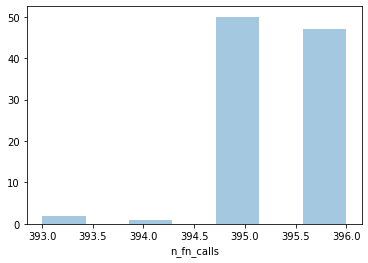

In [109]:
sns.distplot(df['n_fn_calls'], kde=False)

<AxesSubplot:xlabel='n_fn_calls', ylabel='qubits'>

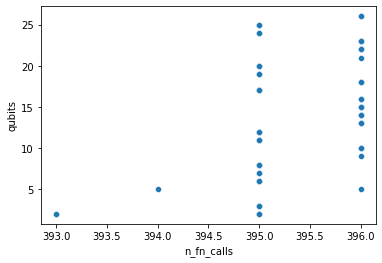

In [110]:
sns.scatterplot(
    data=df,
    x='n_fn_calls',
    y='qubits'
)

In [134]:
def inspect_encoding(encoding, n_qubits, classical_input):
    qasm_string = encoding_to_circuit(
        encoding, 
        n_qubits=n_qubits, 
        classical_input=classical_input)
    
    # create the circuit
    circuit = QuantumCircuit.from_qasm_str(qasm_string)
    print(circuit)

In [141]:
subset = df[df['n_fn_calls'] == 393]
if len(subset) > 0:
    first_record = subset.iloc[0]
else:
    print('Empty')
subset.head()

,random_encoding,qubits,input,results,fn_calls,n_fn_calls
76,"[0.3745401188473625, 0.9507143064099162, 0.731...",2,0,"{'01': 171, '11': 268, '00': 56, '10': 529}","['/qiskit/execute_function.py:39(execute)', '/...",393
80,"[0.3745401188473625, 0.9507143064099162, 0.731...",2,0,"{'11': 283, '01': 169, '00': 60, '10': 512}","['/qiskit/execute_function.py:39(execute)', '/...",393


In [142]:
inspect_encoding(
    encoding=first_record['random_encoding'],
    n_qubits=first_record['qubits'],
    classical_input=int(first_record['input']))

      ░ ┌───┐┌─────────────┐┌───┐┌────────────┐┌────────────┐     »
q_0: ─░─┤ X ├┤ Ry(0.98014) ├┤ X ├┤ Ry(6.0941) ├┤ Rz(1.1424) ├──■──»
      ░ └─┬─┘└─────────────┘└─┬─┘└────────────┘└────────────┘┌─┴─┐»
q_1: ─░───■───────────────────■──────────────────────────────┤ X ├»
      ░                                                      └───┘»
c: 2/═════════════════════════════════════════════════════════════»
                                                                  »
«     ┌────────────┐     ┌─────────────┐                                     »
«q_0: ┤ Rx(3.8444) ├──■──┤ Ry(0.40873) ├──────────────────────────────────■──»
«     └────────────┘┌─┴─┐└┬────────────┤┌─────────────┐┌───────────────┐┌─┴─┐»
«q_1: ──────────────┤ X ├─┤ Rx(1.2546) ├┤ Rx(0.29186) ├┤ U(0,5.0793,0) ├┤ X ├»
«                   └───┘ └────────────┘└─────────────┘└───────────────┘└───┘»
«c: 2/═══════════════════════════════════════════════════════════════════════»
«                                                 

In [148]:
functions

['/qiskit/execute_function.py:39(execute)',
 '/qiskit/tools/parallel.py:96(parallel_map)',
 '/qiskit/compiler/transpiler.py:47(transpile)',
 '/qiskit/compiler/transpiler.py:341(_transpile_circuit)',
 '/qiskit/transpiler/passmanager.py:174(run)',
 '/qiskit/transpiler/passmanager.py:257(_run_single_circuit)',
 '/qiskit/transpiler/runningpassmanager.py:103(run)',
 '/qiskit/transpiler/runningpassmanager.py:134(_do_pass)',
 '/qiskit/transpiler/runningpassmanager.py:161(_run_this_pass)',
 '/qiskit/transpiler/passes/optimization/optimize_1q_decomposition.py:67(run)',
 '/qiskit/transpiler/passes/optimization/optimize_1q_decomposition.py:96(<dictcomp>)',
 '/qiskit/quantum_info/synthesis/one_qubit_decompose.py:166(_decompose)',
 '/qiskit/quantum_info/synthesis/one_qubit_decompose.py:466(_circuit_psx_gen)',
 '/qiskit/quantum_info/synthesis/one_qubit_decompose.py:221(_params_zyz)',
 '/qiskit/quantum_info/synthesis/one_qubit_decompose.py:297(_circuit_kak)',
 '/qiskit/circuit/quantumcircuit.py:152(_

In [149]:
import json

def check_different_function_calls(record_a, record_b):
    
    functions_a = set(json.loads(record_a['fn_calls'].replace("'", '"')))
    functions_b = set(json.loads(record_b['fn_calls'].replace("'", '"')))
    
    instersection = functions_a.intersection(functions_b)
    
    print('function only in a:')
    print(functions_a.difference(instersection))
    print('function only in b:')
    print(functions_b.difference(instersection))

In [150]:
check_different_function_calls(
    record_a=df[df['n_fn_calls'] == 393].iloc[0], 
    record_b=df[df['n_fn_calls'] == 394].iloc[0])

function only in a:
set()
function only in b:
{'/qiskit/circuit/library/standard_gates/u1.py:121(__array__)'}


In [151]:
check_different_function_calls(
    record_a=df[df['n_fn_calls'] == 393].iloc[0], 
    record_b=df[df['n_fn_calls'] == 395].iloc[0])

function only in a:
set()
function only in b:
{'/qiskit/circuit/library/standard_gates/x.py:115(__array__)', '/qiskit/quantum_info/synthesis/one_qubit_decompose.py:570(fnxpi)'}


In [152]:
check_different_function_calls(
    record_a=df[df['n_fn_calls'] == 393].iloc[0], 
    record_b=df[df['n_fn_calls'] == 396].iloc[0])

function only in a:
set()
function only in b:
{'/qiskit/circuit/library/standard_gates/u1.py:121(__array__)', '/qiskit/circuit/library/standard_gates/x.py:115(__array__)', '/qiskit/quantum_info/synthesis/one_qubit_decompose.py:570(fnxpi)'}


In [153]:
check_different_function_calls(
    record_a=df[df['n_fn_calls'] == 395].iloc[0], 
    record_b=df[df['n_fn_calls'] == 396].iloc[0])

function only in a:
set()
function only in b:
{'/qiskit/circuit/library/standard_gates/u1.py:121(__array__)'}
